# Define the helper functions

In [2]:
interactive_fig = None
interactive_fig_styles = None

def plot_images(images, titles, figure_size):
    %matplotlib inline
    if interactive_fig is not None:
        plt.close(interactive_fig)
    if interactive_fig_styles is not None:
        plt.close(interactive_fig_styles)
    plt.figure(figsize=(figure_size, figure_size))
    for i in range(len(images)):
        image = images[i]
        title = titles[i]
        plt.subplot(1, len(images), i + 1)
        plt.imshow(image)
        plt.title(title)
        plt.axis('off')

def resize_to(image, target):
    target_height, target_width = target.shape[:2]
    image = cv2.resize(image, (target_width, target_height), interpolation=cv2.INTER_LINEAR)
    return image

def regenerate(org_image, masked_image, mask):
    inverse_mask = cv2.bitwise_not(mask)
    masked_original = cv2.bitwise_and(org_image, org_image, mask=inverse_mask)
    styled_masked = cv2.bitwise_and(masked_image, masked_image, mask=mask)
    return cv2.add(masked_original, styled_masked) 

In [3]:
#from libs.Matrix_masked import MulLayer as MulLayer_m
#from libs.models_masked import encoder4 as encoder_m, decoder4 as decoder_m
#
#enc_ref_m = encoder_m()
#dec_ref_m = decoder_m()
#matrix_ref_m = MulLayer_m('r41')
#
#enc_ref_m.load_state_dict(torch.load('models/vgg_r41.pth'))
#dec_ref_m.load_state_dict(torch.load('models/dec_r41.pth'))
#matrix_ref_m.load_state_dict(torch.load('models/r41.pth',map_location=torch.device('cpu')))
#
#
#def masked_style_transfer(content, style, mask):
#    with torch.no_grad():
#        cF_ref,small_mask = enc_ref_m(content_im,masked_im)
#        sF_ref,_ = enc_ref_m(style_im)
#        feature_ref,transmatrix_ref = matrix_ref_m(cF_ref['r41'],sF_ref['r41'],small_mask)
#        result = dec_ref_m(feature_ref,masked_im)
#        
#    return result

# Define the algorithm functions

In [4]:
import os
import subprocess
from libs.Matrix import MulLayer
from libs.models import encoder4, decoder4
from libs.Matrix_masked import MulLayer as MulLayer_m
from libs.models_masked import encoder4 as encoder_m, decoder4 as decoder_m
import os
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import cv2
from PIL import Image

def image_to_tensor(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = F.to_tensor(image)
    image_tensor = image_tensor.unsqueeze(0)
    return image_tensor

def tensor_to_image(tensor):
    tensor = tensor.squeeze(0)
    image = tensor.detach().cpu().numpy()
    image = np.transpose(image, (1, 2, 0))
    image = (image * 255).clip(0, 255).astype(np.uint8)
    return image

enc_ref = encoder4()
dec_ref = decoder4()
matrix_ref = MulLayer('r41')

enc_ref.load_state_dict(torch.load('./models/vgg_r41.pth'))
dec_ref.load_state_dict(torch.load('./models/dec_r41.pth'))
matrix_ref.load_state_dict(torch.load('./models/r41.pth',map_location=torch.device('cpu')))

def style_transfer(content_im, style_im):
    with torch.no_grad():
        cF_ref = enc_ref(image_to_tensor(content_im))
        sF_ref = enc_ref(image_to_tensor(style_im))
        feature_ref, transmatrix_ref = matrix_ref(cF_ref['r41'], sF_ref['r41'])
        result = dec_ref(feature_ref)
    return tensor_to_image(result)


enc_ref_m = encoder_m()
dec_ref_m = decoder_m()
matrix_ref_m = MulLayer_m('r41')

enc_ref_m.load_state_dict(torch.load('models/vgg_r41.pth'))
dec_ref_m.load_state_dict(torch.load('models/dec_r41.pth'))
matrix_ref_m.load_state_dict(torch.load('models/r41.pth', map_location=torch.device('cpu')))


def partial_convolution(content_im, mask, style_image_file):
    masked_im = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    style_im = cv2.imread(style_image_file)
    
    with torch.no_grad():
        content_tensor = image_to_tensor(content_im)
        style_tensor = image_to_tensor(style_im)
        mask_tensor = image_to_tensor(masked_im)
        mask_tensor = mask_tensor[:, 0:1, :, :]
        
        cF_ref, small_mask = enc_ref_m(content_tensor, mask_tensor)
        sF_ref, _ = enc_ref_m(style_tensor)
        feature_ref, transmatrix_ref = matrix_ref_m(cF_ref['r41'], sF_ref['r41'], small_mask)
        result = dec_ref_m(feature_ref, mask_tensor)
        
    processed_image_rgb = tensor_to_image(result)
    processed_image_rgb = resize_to(processed_image_rgb, content_im)
    processed_image_rgb = regenerate(cv2.cvtColor(content_im, cv2.COLOR_BGR2RGB), processed_image_rgb, mask)
    return processed_image_rgb

def style_and_mask(image, mask, style_image_file):
    styled_image = style_transfer(image, cv2.imread(style_image_file))
    
    ### resize styled image to original size    
    org_styled_image = resize_to(styled_image, image)
    
    return regenerate(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), org_styled_image, mask)

def mask_and_style(image, mask, style_image_file):
    masked_image_file = './output/masked.jpg'
    masked_styled_image_file = './output/masked-styled.jpg'
    
    ### mask the original image
    masked_image = cv2.bitwise_and(image, image, mask=mask)

    ### style the masked image
    masked_styled_image = style_transfer(masked_image, cv2.imread(style_image_file))
    
    ### resize styled image to original size    
    resized_masked_styled_image = resize_to(masked_styled_image, image)

    ### regenerating masked-style image
    return regenerate(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), resized_masked_styled_image, mask)

def bbox_mask_and_style(image, mask, style_image_file):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    bboxed_image_file = './output/bboxed-masked.jpg'
    bboxed_styled_image_file = './output/bboxed-masked-style.jpg'

    bbox = masks[mask_index]['bbox']

    ### bbox and mask the original image
    x, y, w, h = bbox
    bboxed_mask = mask[y:y+h, x:x+w]
    original_bboxed_image = image[y:y+h, x:x+w]
    masked_bboxed_image = cv2.bitwise_and(original_bboxed_image, original_bboxed_image, mask=bboxed_mask)
    
    ### style the bboxed image
    bboxed_styled_image = style_transfer(masked_bboxed_image, cv2.imread(style_image_file))
    
    ### resize masked styled image
    bboxed_styled_image = cv2.resize(bboxed_styled_image, (w, h))
    masked_styled_bboxed_image = cv2.bitwise_and(bboxed_styled_image, bboxed_styled_image, mask=bboxed_mask)

    ### regenerating bboxed styles original image
    inverse_mask = cv2.bitwise_not(bboxed_mask)
    masked_original_bboxed_image = cv2.bitwise_and(original_bboxed_image, original_bboxed_image, mask=inverse_mask)
    
    final_bboxed_masked_styled_image = cv2.add(masked_styled_bboxed_image, masked_original_bboxed_image) 
    
    ### inject styled bboxed image into original image
    bbox_masked_styled_image = cv2.cvtColor(cv2.imread(original_image_name), cv2.COLOR_BGR2RGB)
    bbox_masked_styled_image[y:y+h, x:x+w] = final_bboxed_masked_styled_image 
    return bbox_masked_styled_image

def bbox_style_and_mask(image, mask, style_image_file):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    bboxed_image_file = './output/bboxed-masked.jpg'
    bboxed_styled_image_file = './output/bboxed-styled-masked.jpg'

    bbox = masks[mask_index]['bbox']
    x, y, w, h = bbox
    original_bboxed_image = image[y:y+h, x:x+w]
    bboxed_mask = mask[y:y+h, x:x+w]

    ### style the bboxed image
    bboxed_styled_image = style_transfer(original_bboxed_image, cv2.imread(style_image_file))
    
    ### mask the styled bboxed image
    bboxed_styled_image = cv2.resize(bboxed_styled_image, (w, h))
    bboxed_styled_masked_image = cv2.bitwise_and(bboxed_styled_image, bboxed_styled_image, mask=bboxed_mask)
    
    ### regenerating bboxed styles original image
    inverse_mask = cv2.bitwise_not(bboxed_mask)
    masked_original_bboxed_image = cv2.bitwise_and(original_bboxed_image, original_bboxed_image, mask=inverse_mask)
    final_bboxed_masked_styled_image = cv2.add(masked_original_bboxed_image, bboxed_styled_masked_image) 
    
    ### inject styled bboxed image into original image
    bbox_masked_styled_image = cv2.cvtColor(cv2.imread(original_image_name), cv2.COLOR_BGR2RGB)
    bbox_masked_styled_image[y:y+h, x:x+w] = final_bboxed_masked_styled_image 
    return bbox_masked_styled_image
    

# Define the variables

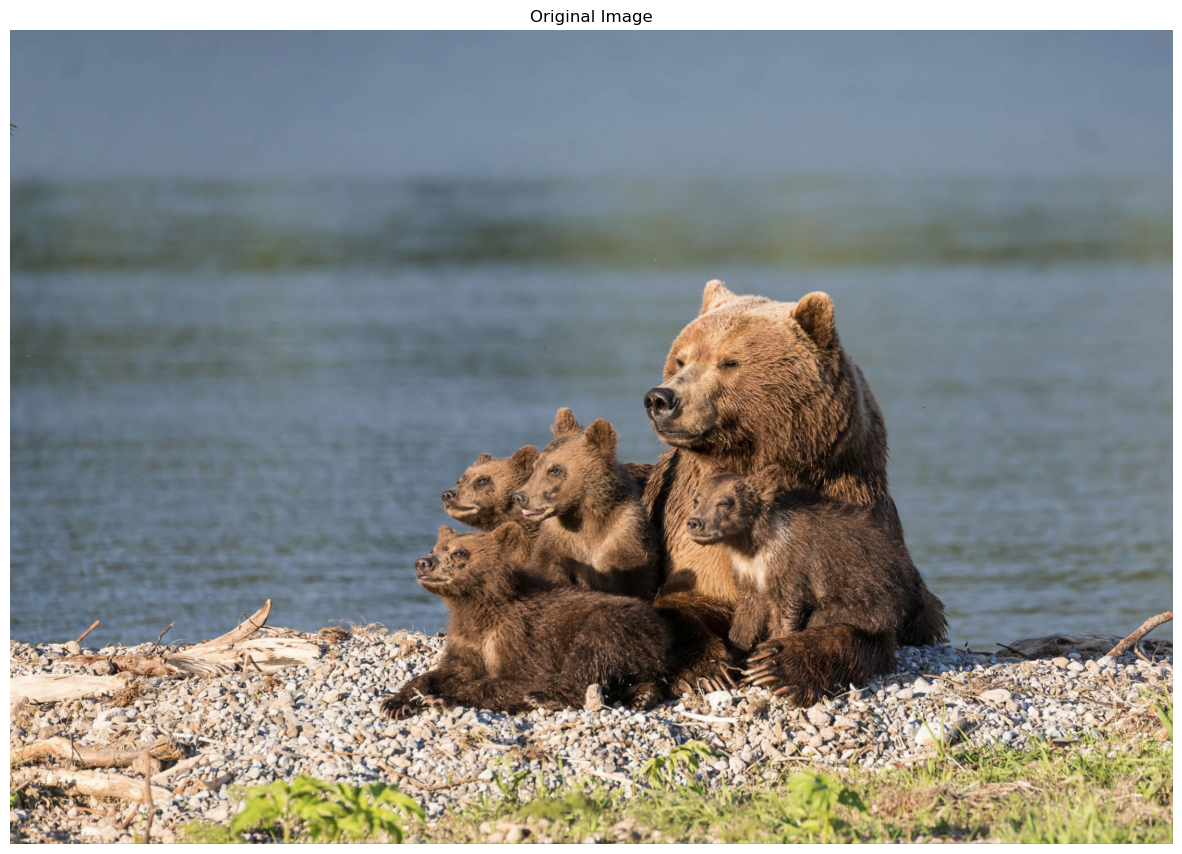

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

linear_style_transfer_file = '/Users/ayberk.cansever/Documents/ECU/Thesis/LinearStyleTransfer/linearstyletransfer.py'
original_image_name = './sources/image-2.png'

image = cv2.imread(original_image_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plot_images([image], ['Original Image'], 15)


# Create SAM mask generator

In [6]:
#import sys
#sys.path.append("..")
#from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
#
#sam_checkpoint = "sam_vit_h_4b8939.pth"
#model_type = "vit_h"
#
#device=torch.device('mps' if torch.cuda.is_available() else 'cpu')
#print(device)
#
#sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
#sam.to(device=device)
#
#mask_generator = SamAutomaticMaskGenerator(sam)

# Create masks

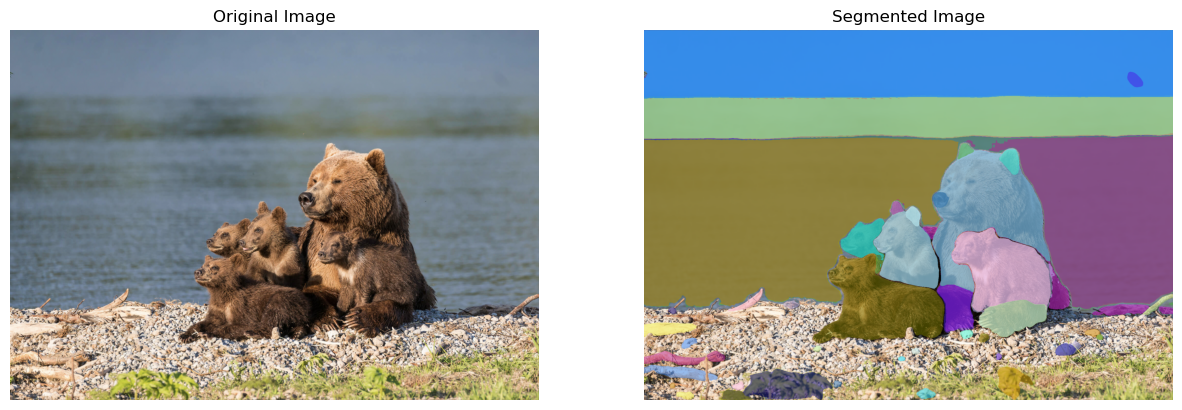

In [7]:
#masks = mask_generator.generate(image)
#with open('masks-image-2.pkl', 'wb') as file:
#    pickle.dump(masks, file)
#print(masks[0].keys())

import pickle
import supervision as sv

with open('masks-image-2.pkl', 'rb') as file:
    masks = pickle.load(file)


segmented_masks = [
    mask['segmentation']
    for mask in masks
]

mask_annotator = sv.MaskAnnotator()
detections = sv.Detections.from_sam(sam_result=masks)

annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
plot_images([image, annotated_image], ['Original Image', 'Segmented Image'], 15)

# Select Mask

<IPython.core.display.Javascript object>


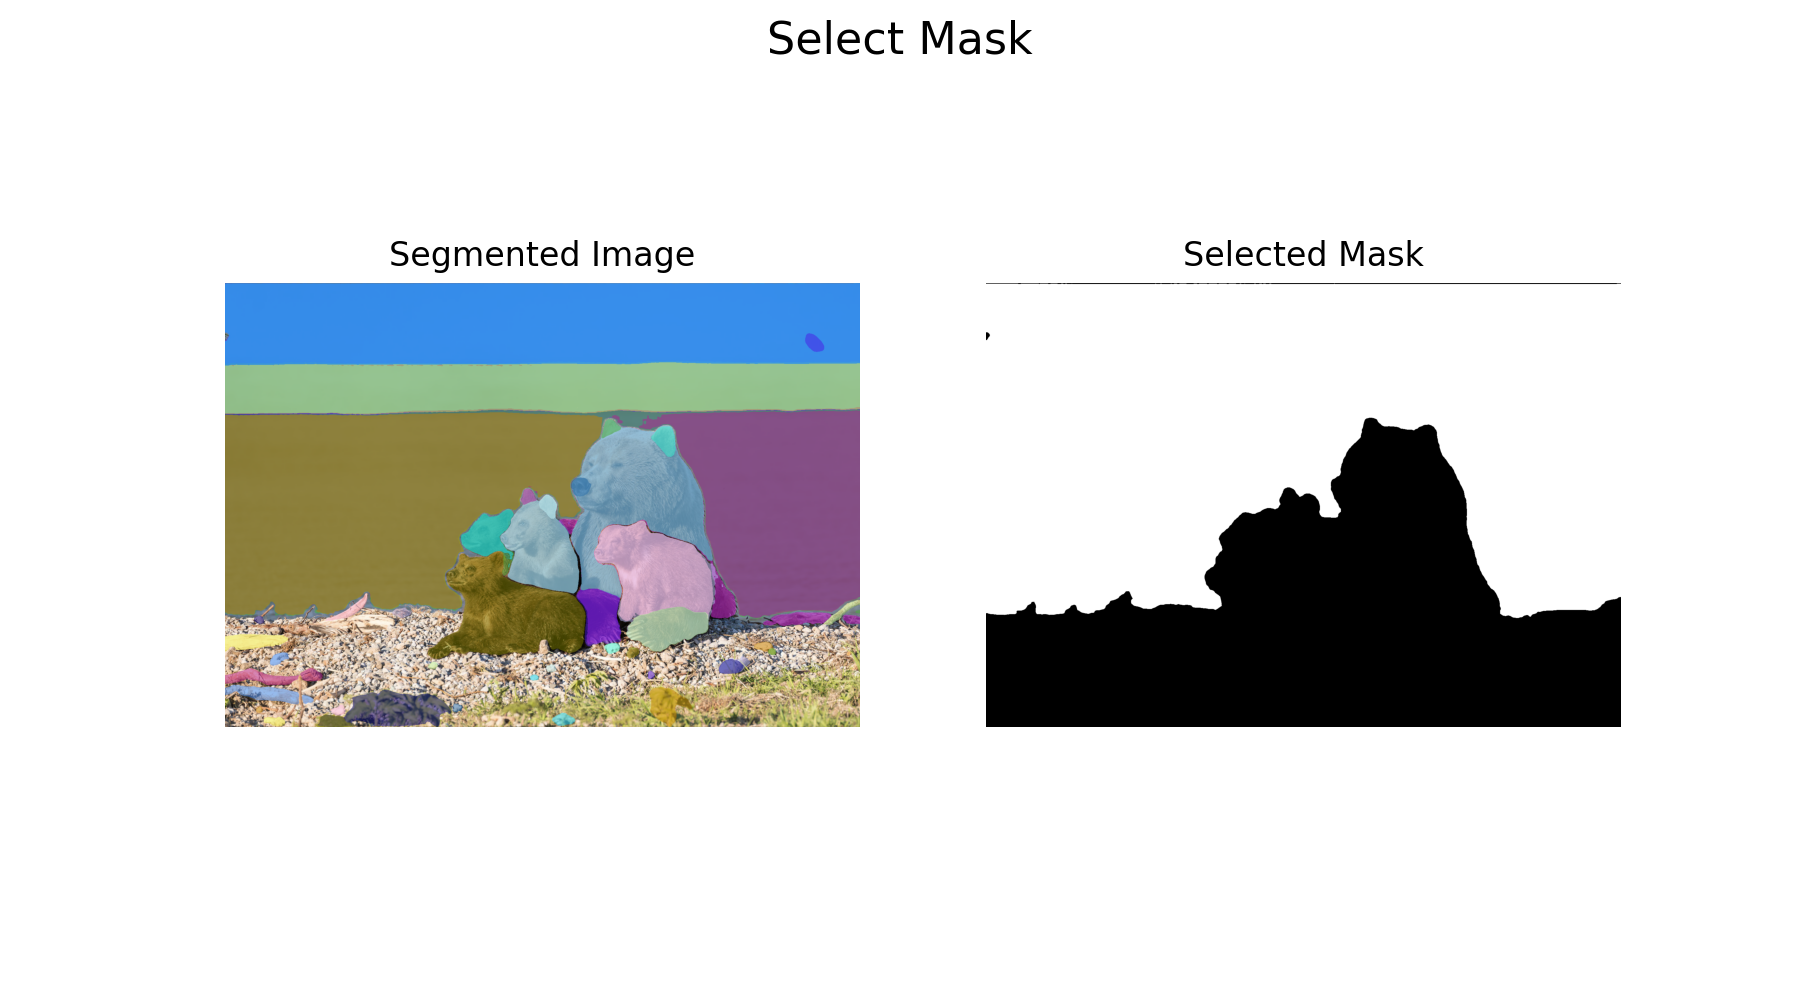

15

In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import cv2
from IPython.display import display
import ipywidgets as widgets

mask_index = 0
mask = (segmented_masks[mask_index] * 255).astype(np.uint8) 

interactive_fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
interactive_fig.suptitle('Select Mask', fontsize=16)

implot1 = ax1.imshow(annotated_image)
ax1.set_title('Segmented Image')
ax1.axis('off')
implot2 = ax2.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
ax2.set_title('Selected Mask')
ax2.axis('off')

def onclick(event):
    global mask 
    global mask_index
    if event.xdata is not None and event.ydata is not None:
        x = int(event.xdata)
        y = int(event.ydata)
        pixel_value = annotated_image[y, x]
        for index, segmented_mask in enumerate(segmented_masks):
            new_mask = (segmented_mask * 255).astype(np.uint8)
            pixel_value = new_mask[y, x]
            if pixel_value == 255:
                mask = (segmented_masks[index] * 255).astype(np.uint8) 
                mask_index = index
                implot2.set_data(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
                interactive_fig.canvas.draw_idle()
                break

implot1.figure.canvas.mpl_connect('button_press_event', onclick)


# Select Style

<IPython.core.display.Javascript object>


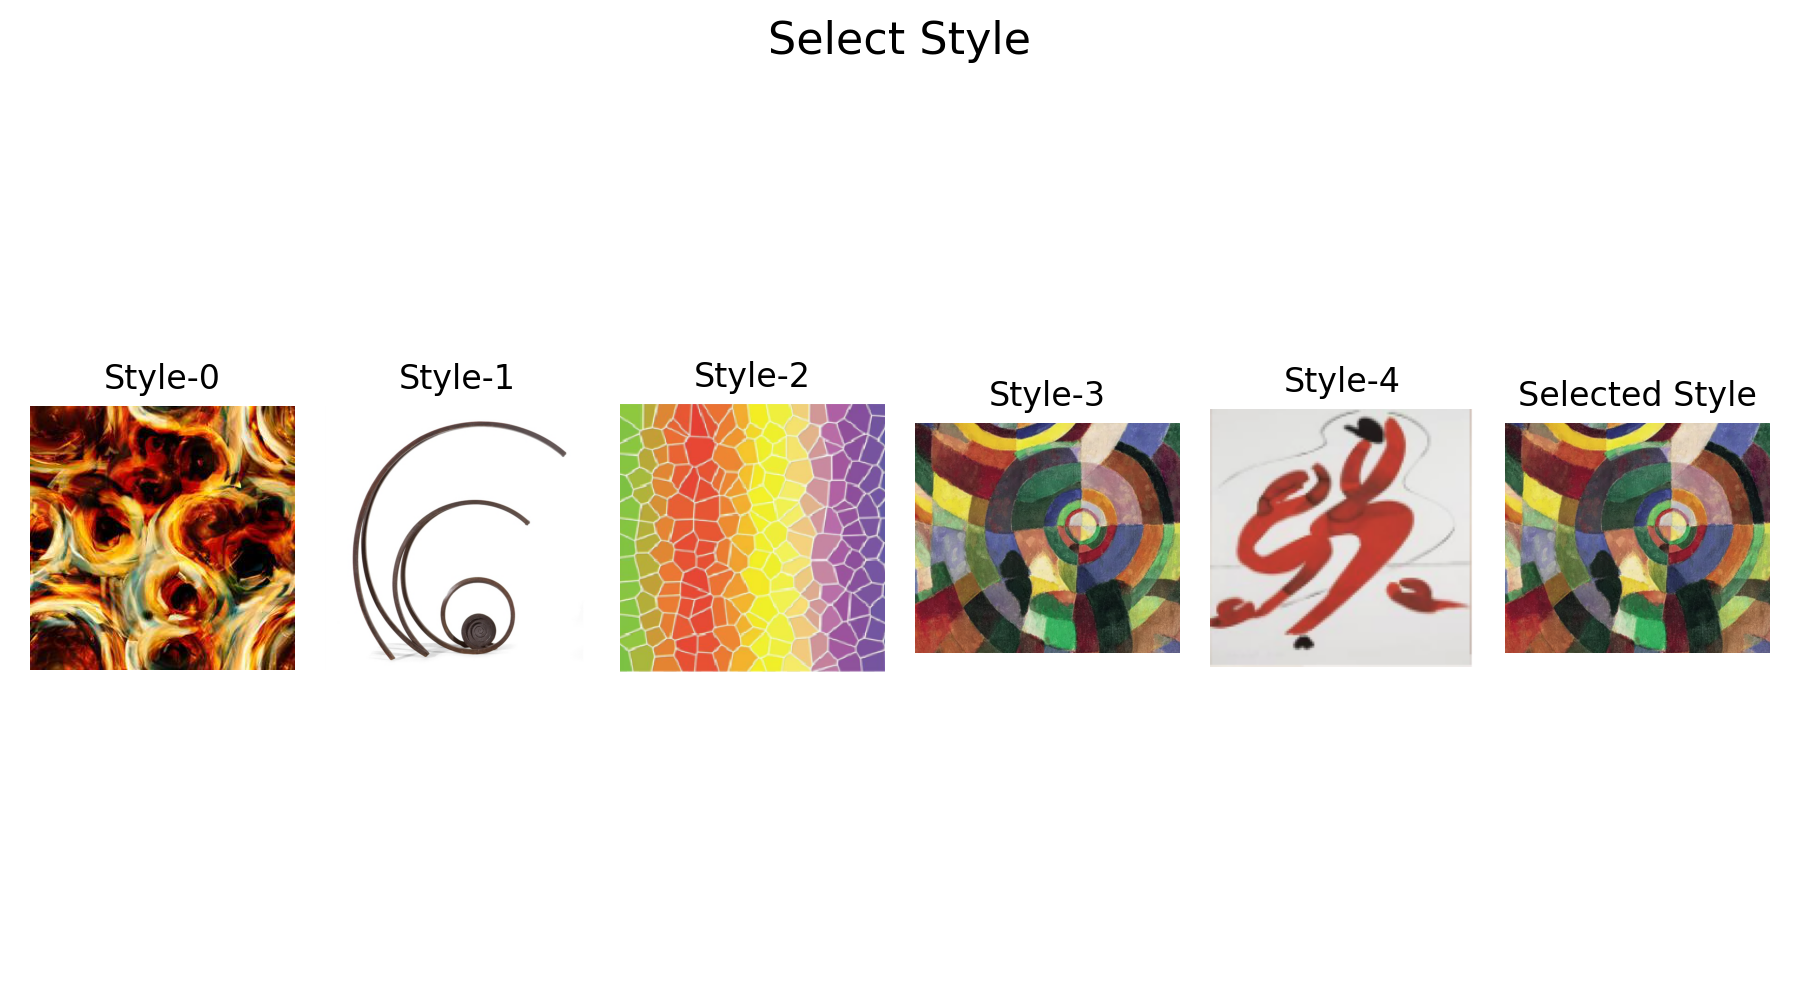

In [51]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import cv2
from IPython.display import display
import ipywidgets as widgets

style_images = [cv2.cvtColor(cv2.imread(f'./styles/style-{i}.jpg'), cv2.COLOR_BGR2RGB) for i in range(5)]

interactive_fig_styles, axs = plt.subplots(1, 6, figsize=(9, 5))
interactive_fig_styles.suptitle('Select Style', fontsize=16)

image_titles = ['Style-0', 'Style-1', 'Style-2', 'Style-3', 'Style-4', 'Selected Style']

for i, ax in enumerate(axs[:-1]):
    ax.imshow(style_images[i])
    ax.set_title(image_titles[i])
    ax.axis('off')

ax_st_selected = axs[-1]
implot_st_selected = ax_st_selected.imshow(style_images[0])
ax_st_selected.set_title(image_titles[-1])
ax_st_selected.axis('off')
style_image_file = f'./styles/style-0.jpg'

def onclick_style(event):
    global style_image_file
    for i, ax in enumerate(axs[:-1]):
        if event.inaxes == ax:
            axs[-1].clear() 
            axs[-1].imshow(style_images[i])
            axs[-1].set_title(image_titles[-1]) 
            axs[-1].axis('off')
            style_image_file = f'./styles/style-{i}.jpg'
            break
    interactive_fig_styles.canvas.draw_idle()

interactive_fig_styles.canvas.mpl_connect('button_press_event', onclick_style)

plt.tight_layout() 
plt.show()

# Select Algorithm

In [8]:
algorithms=['Style And Mask', 'Mask And Style', 'BBox Style and Mask', 'BBox Mask and Style', 'Partial Convolution']
dropdown = widgets.Dropdown(
    options=algorithms,  
    value='Style And Mask',
    description='Algorithm:',
    disabled=False,
)
display(dropdown)

Dropdown(description='Algorithm:', options=('Style And Mask', 'Mask And Style', 'BBox Style and Mask', 'BBox M…

# Process

Partial Convolution processing...


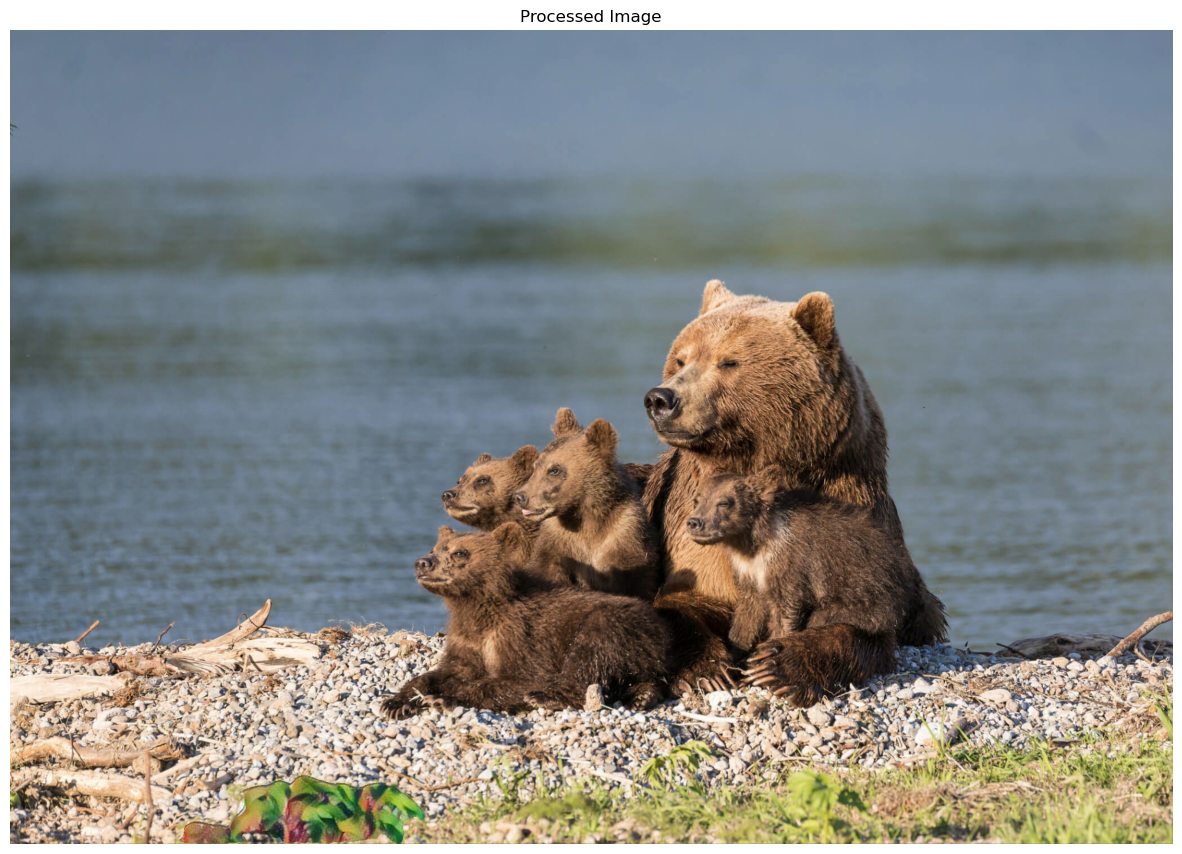

In [57]:
import numpy as np

selected_index = dropdown.index
algorithm = algorithms[selected_index]
print(f'{algorithm} processing...')

processed_image_filename = 'processed_image.jpg'

os.remove('processed_image.jpg')

if os.path.isfile(processed_image_filename):
    image_to_be_processed = cv2.imread(processed_image_filename)
else:
    image_to_be_processed = cv2.imread(original_image_name)

if selected_index == 0:
    processed_image = style_and_mask(image_to_be_processed, mask, style_image_file)
elif selected_index == 1:
    processed_image = mask_and_style(image_to_be_processed, mask, style_image_file)
elif selected_index == 2:
    processed_image = bbox_style_and_mask(image_to_be_processed, mask, style_image_file)
elif selected_index == 3:
    processed_image = bbox_mask_and_style(image_to_be_processed, mask, style_image_file)
elif selected_index == 4:
    processed_image = partial_convolution(image_to_be_processed, mask, style_image_file)
    
processed_image_rgb = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)
cv2.imwrite('processed_image.jpg', processed_image_rgb) 

plot_images([processed_image], ['Processed Image'], 15)


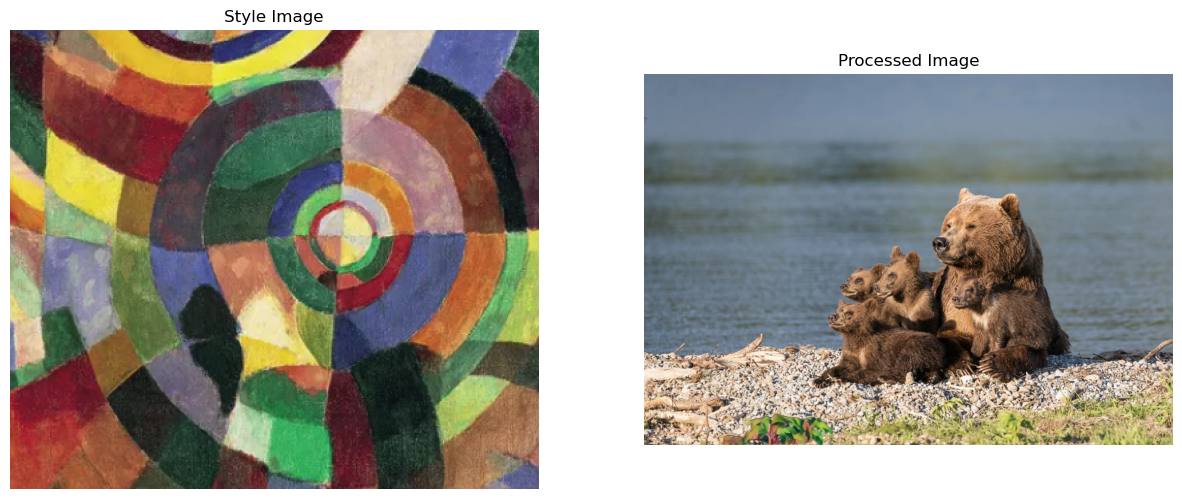

In [59]:
style_image = cv2.imread(style_image_file)
style_image = cv2.cvtColor(style_image, cv2.COLOR_BGR2RGB)

styled_image = cv2.imread('quantification/3_processed_partial_conv.jpg')
styled_image = cv2.cvtColor(styled_image, cv2.COLOR_BGR2RGB)

plot_images([style_image, styled_image], ['Style Image', 'Processed Image'], 15)

# Style Image Statistics

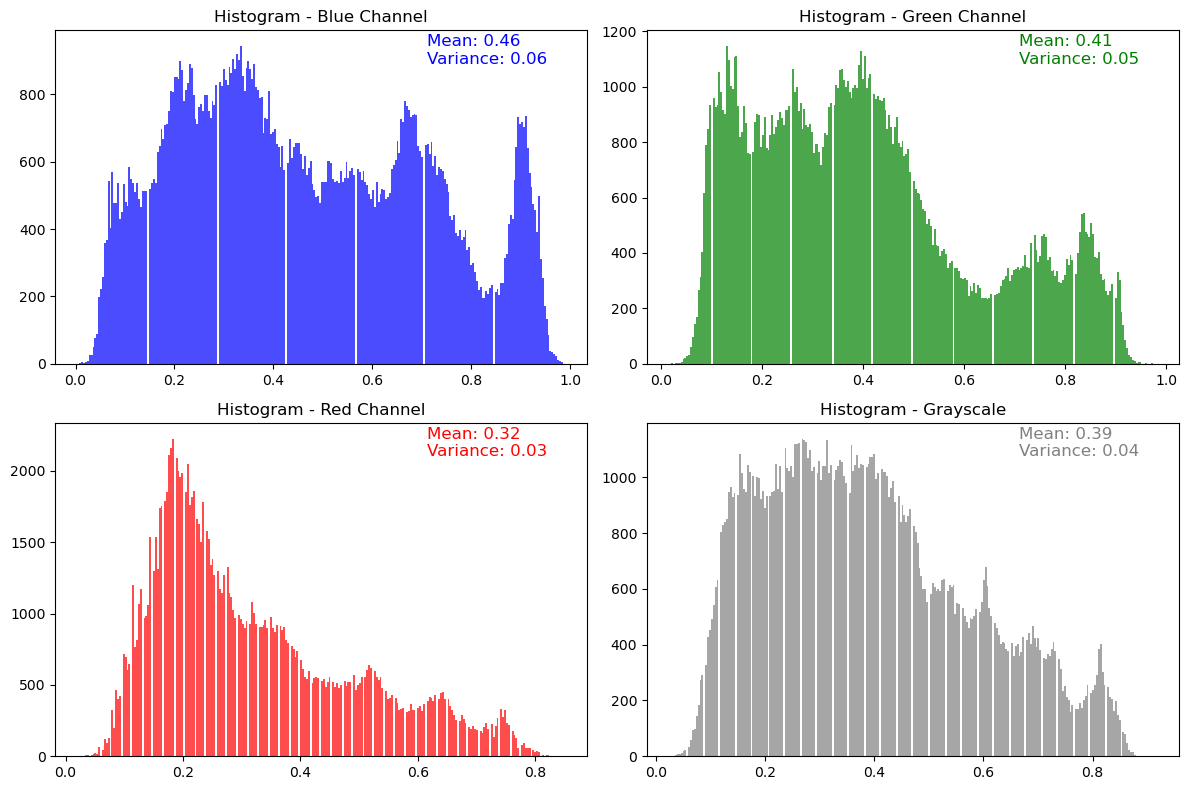

In [60]:
# Normalize pixel values (scale to 0-1 range)
blue_values = style_image[:, :, 0].flatten() / 255.0  # Blue channel normalized
green_values = style_image[:, :, 1].flatten() / 255.0  # Green channel normalized
red_values = style_image[:, :, 2].flatten() / 255.0  # Red channel normalized

# Convert to grayscale and normalize
gray_image = cv2.cvtColor(style_image, cv2.COLOR_BGR2GRAY)
gray_values = gray_image.flatten() / 255.0  # Normalize grayscale

# Exclude black (0) and white (1) pixels after normalization
blue_values = blue_values[(blue_values > 0) & (blue_values < 1)]  # Exclude 0s and 1s
green_values = green_values[(green_values > 0) & (green_values < 1)]  # Exclude 0s and 1s
red_values = red_values[(red_values > 0) & (red_values < 1)]  # Exclude 0s and 1s
gray_values = gray_values[(gray_values > 0) & (gray_values < 1)]  # Exclude 0s and 1s

# Calculate mean and variance for each channel
mean_blue, var_blue = np.mean(blue_values), np.var(blue_values)
mean_green, var_green = np.mean(green_values), np.var(green_values)
mean_red, var_red = np.mean(red_values), np.var(red_values)
mean_gray, var_gray = np.mean(gray_values), np.var(gray_values)

# Plot the histograms for BGR channels and Grayscale in a 2x2 grid
plt.figure(figsize=(12, 8))  # Adjust the figure size as needed

plt.subplot(2, 2, 1)
plt.hist(blue_values, bins=256, color='blue', alpha=0.7)
plt.title('Histogram - Blue Channel')
plt.text(0.7, 0.9, f'Mean: {mean_blue:.2f}\nVariance: {var_blue:.2f}', transform=plt.gca().transAxes, fontsize=12, color='blue')

plt.subplot(2, 2, 2)
plt.hist(green_values, bins=256, color='green', alpha=0.7)
plt.title('Histogram - Green Channel')
plt.text(0.7, 0.9, f'Mean: {mean_green:.2f}\nVariance: {var_green:.2f}', transform=plt.gca().transAxes, fontsize=12, color='green')

plt.subplot(2, 2, 3)
plt.hist(red_values, bins=256, color='red', alpha=0.7)
plt.title('Histogram - Red Channel')
plt.text(0.7, 0.9, f'Mean: {mean_red:.2f}\nVariance: {var_red:.2f}', transform=plt.gca().transAxes, fontsize=12, color='red')

plt.subplot(2, 2, 4)
plt.hist(gray_values, bins=256, color='gray', alpha=0.7)
plt.title('Histogram - Grayscale')
plt.text(0.7, 0.9, f'Mean: {mean_gray:.2f}\nVariance: {var_gray:.2f}', transform=plt.gca().transAxes, fontsize=12, color='gray')

plt.tight_layout()
plt.show()

# Styled Image Statistics

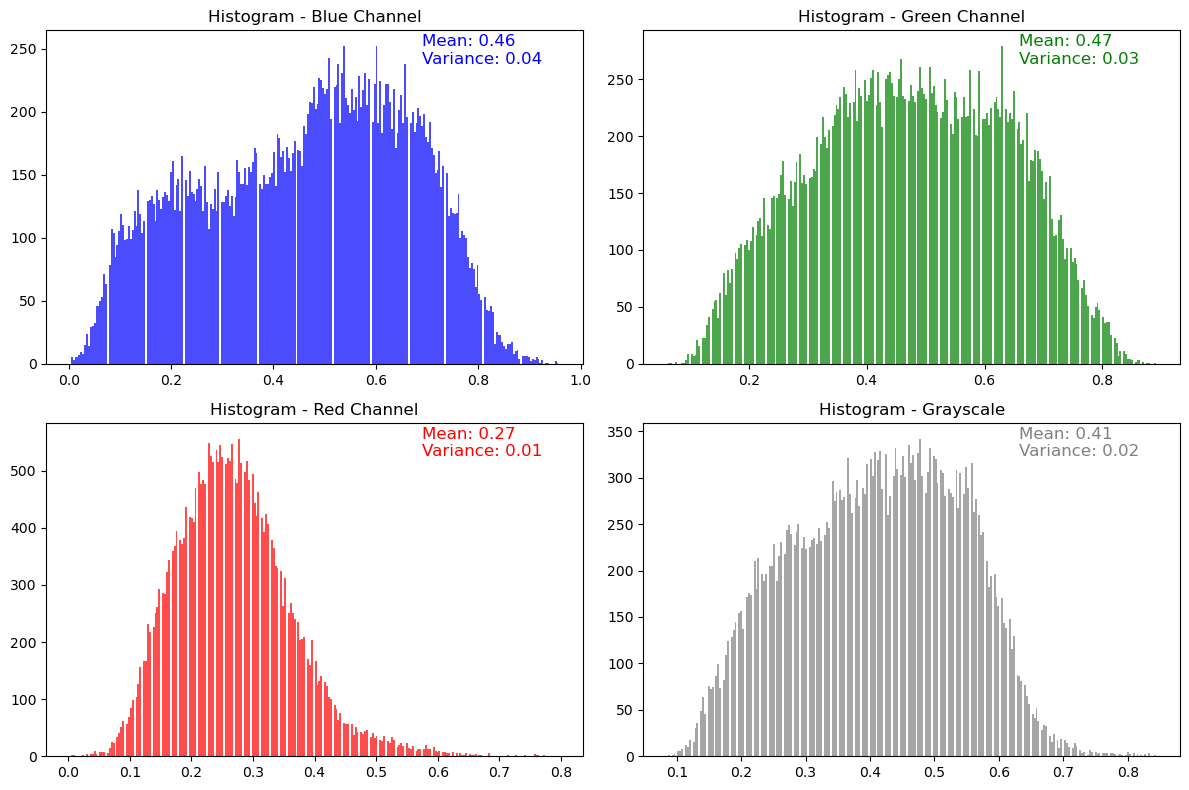

In [61]:
mask_bool = mask > 0  

# Extract and normalize pixel values from the masked region for each color channel (BGR)
blue_values = styled_image[mask_bool][:, 0] / 255.0  # Normalize Blue channel
green_values = styled_image[mask_bool][:, 1] / 255.0  # Normalize Green channel
red_values = styled_image[mask_bool][:, 2] / 255.0  # Normalize Red channel

# Convert to grayscale, apply the mask, and normalize
gray_image = cv2.cvtColor(styled_image, cv2.COLOR_BGR2GRAY)
gray_values = gray_image[mask_bool] / 255.0  # Normalize Grayscale values

# Exclude black (0) and white (1) pixels after normalization
blue_values = blue_values[(blue_values > 0) & (blue_values < 1)]
green_values = green_values[(green_values > 0) & (green_values < 1)]
red_values = red_values[(red_values > 0) & (red_values < 1)]
gray_values = gray_values[(gray_values > 0) & (gray_values < 1)]

mean_blue, var_blue = np.mean(blue_values), np.var(blue_values)
mean_green, var_green = np.mean(green_values), np.var(green_values)
mean_red, var_red = np.mean(red_values), np.var(red_values)
mean_gray, var_gray = np.mean(gray_values), np.var(gray_values)

plt.figure(figsize=(12, 8))  

plt.subplot(2, 2, 1)
plt.hist(blue_values, bins=256, color='blue', alpha=0.7)
plt.title('Histogram - Blue Channel')
plt.text(0.7, 0.9, f'Mean: {mean_blue:.2f}\nVariance: {var_blue:.2f}', transform=plt.gca().transAxes, fontsize=12, color='blue')

plt.subplot(2, 2, 2)
plt.hist(green_values, bins=256, color='green', alpha=0.7)
plt.title('Histogram - Green Channel')
plt.text(0.7, 0.9, f'Mean: {mean_green:.2f}\nVariance: {var_green:.2f}', transform=plt.gca().transAxes, fontsize=12, color='green')

plt.subplot(2, 2, 3)
plt.hist(red_values, bins=256, color='red', alpha=0.7)
plt.title('Histogram - Red Channel')
plt.text(0.7, 0.9, f'Mean: {mean_red:.2f}\nVariance: {var_red:.2f}', transform=plt.gca().transAxes, fontsize=12, color='red')

plt.subplot(2, 2, 4)
plt.hist(gray_values, bins=256, color='gray', alpha=0.7)
plt.title('Histogram - Grayscale')
plt.text(0.7, 0.9, f'Mean: {mean_gray:.2f}\nVariance: {var_gray:.2f}', transform=plt.gca().transAxes, fontsize=12, color='gray')

plt.tight_layout()
plt.show()
